# FDA

Introduction and explanation of outline

## Part 1 - Data Fitting

In [34]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
cwd = os.getcwd()
relative_path_x,relative_path_y = r'Letters/Data/xdata_abc.csv',r'Letters/Data/ydata_abc.csv'
xdata,ydata = pd.read_csv(os.path.join(cwd, relative_path_x)),pd.read_csv(os.path.join(cwd, relative_path_y))
xdata.head()

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,0.806452,0.765161,0.734194,0.865806,0.708387,0.749677,0.744516,0.716129,0.705806,0.760000,...,0.685161,0.721290,0.569032,0.790968,0.651613,0.775484,0.762581,0.584516,0.736774,0.579355
1,0.806452,0.680000,0.685161,0.809032,0.674839,0.726452,0.710968,0.698065,0.625806,0.718710,...,0.587097,0.695484,0.507097,0.762581,0.633548,0.741935,0.734194,0.522581,0.705806,0.543226
2,0.765161,0.594839,0.602581,0.723871,0.630968,0.667097,0.659355,0.669677,0.561290,0.638710,...,0.509677,0.664516,0.421935,0.734194,0.584516,0.708387,0.705806,0.458065,0.643871,0.486452
3,0.680000,0.486452,0.538065,0.630968,0.576774,0.594839,0.600000,0.623226,0.499355,0.550968,...,0.440000,0.625806,0.378065,0.700645,0.548387,0.669677,0.672258,0.393548,0.576774,0.440000
4,0.615484,0.421935,0.486452,0.532903,0.543226,0.522581,0.532903,0.587097,0.432258,0.489032,...,0.378065,0.587097,0.310968,0.646452,0.509677,0.625806,0.628387,0.334194,0.527742,0.401290


**Import Letter Data Analysis Class**

In [5]:
from Letters.readdata import letterData

In [6]:
letterdata = letterData(os.path.join(cwd, relative_path_x),os.path.join(cwd, relative_path_y))

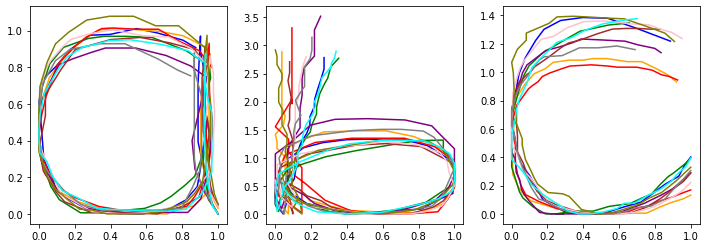

In [8]:
#plot all letters - x vs y
letterdata.agg_plot_letters()

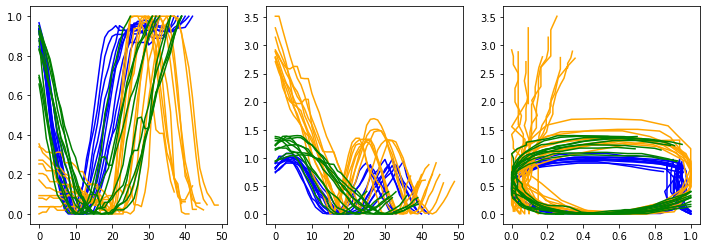

In [10]:
#plot all values for 1.x,2.y,3.letters a-blue ,b-orange ,c-green
letterdata.combined_plot()

Fit B-Splines

In [11]:
#take all X data, and use Xsmooth with evenly sized vectors by using the SplEv tool
from scipy import interpolate
Bspline_coeff = letterdata.coefficients
X = pd.DataFrame(np.zeros(letterdata.x.shape),columns = letterdata.x.columns)
for i,col in enumerate(X.columns):
    X[col] = interpolate.splev(
        np.linspace(0,np.sum(~letterdata.x[col].isnull()) - 1,50),
        (Bspline_coeff['tx'].iloc[i],Bspline_coeff['cx'].iloc[i],Bspline_coeff['kx'].iloc[i]))

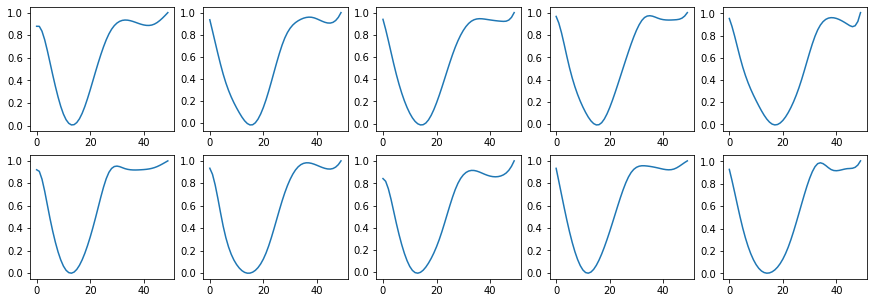

In [12]:
#check visuals are coherent for 'a0-9' values (10 a letters)
fig,axes = plt.subplots(2,5,figsize = (15,5))
for i in range(10):
    axes[i//5,i%5].plot(np.arange(50),X['a{}'.format(i)])

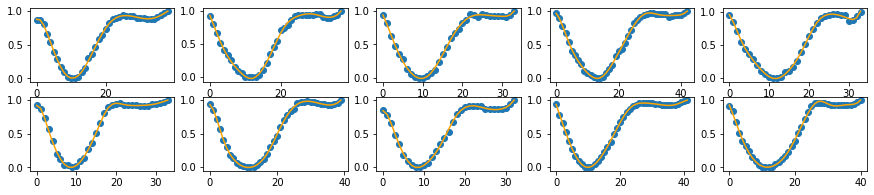

In [13]:
#Compare x curves for a with letter data original values (unsmoothed)
letterdata.single_plotx()

## Part 2 Functional Representation

In [16]:
from sklearn.model_selection import train_test_split
from skfda.datasets import fetch_growth
from skfda.exploratory.depth import ModifiedBandDepth
from skfda.exploratory.stats.covariance import ParametricGaussianCovariance
from skfda.misc.covariances import Gaussian
from skfda.ml.classification import (
    KNeighborsClassifier,
    MaximumDepthClassifier,
    NearestCentroid,
    QuadraticDiscriminantAnalysis,
)

In [14]:
from skfda.representation.grid import FDataGrid

X_data_matrix = [np.array(X[col]) for col in X.columns]
X_grid_points = [i for i in range(X.shape[0])]
X_FData = FDataGrid(X_data_matrix,X_grid_points,
                   dataset_name = 'Xletterdata_abc',
                   argument_names = ('time',),
                   coordinate_names = ('x_position',)
                   )
X_FData

FDataGrid(
    array([[[0.87828924],
            [0.87776323],
            [0.83459993],
            ...,
            [0.95064368],
            [0.97430251],
            [0.99926836]],
    
           [[0.93638992],
            [0.83541622],
            [0.73219906],
            ...,
            [0.92949889],
            [0.95816259],
            [1.001373  ]],
    
           [[0.93974368],
            [0.8495859 ],
            [0.7490728 ],
            ...,
            [0.93347287],
            [0.95745935],
            [1.00053653]],
    
           ...,
    
           [[0.68723162],
            [0.63230418],
            [0.56572324],
            ...,
            [0.95369139],
            [0.9756885 ],
            [0.99983375]],
    
           [[0.91331707],
            [0.86603812],
            [0.80273327],
            ...,
            [0.87625802],
            [0.93416169],
            [1.00231262]],
    
           [[0.70217886],
            [0.64968208],
            [0.584413

In [15]:
#lable data with y values
y = [c[0] for c in X.columns]
mapping = {'a':0,'b':1,'c':2}
categories = [*mapping]
y = np.array([mapping[l] for l in y])
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

Split data into test and train to evaluate prediction of time series data

Only using x curves (univariate data)

The number of a samples is 7
The number of b samples is 7
The number of c samples is 7


C:\Users\George\AppData\Local\Temp\ipykernel_16380\2945169423.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  X_train.plot(group = y_train, group_names = categories).show()


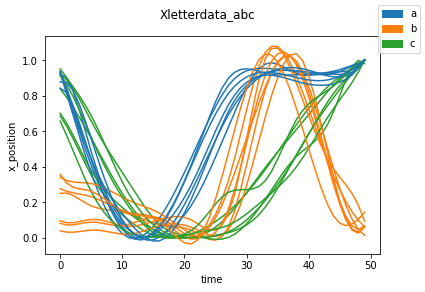

In [17]:
#split test train - ensure with random state equal split of categories
X_train,X_test,y_train,y_test = train_test_split(
    X_FData,
    y,
    test_size = 0.3,
    stratify = y,
    random_state = 7)

#Check for correct representation
print('The number of a samples is {}'.format(np.sum(y_train == 0)))
print('The number of b samples is {}'.format(np.sum(y_train == 1)))
print('The number of c samples is {}'.format(np.sum(y_train == 2)))

#Plot samples grouped by categories
X_train.plot(group = y_train, group_names = categories).show()

Evaluate model performance

In [18]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(knn_pred)
print('The score of KNN is {0:2.2%}'.format(knn.score(X_test, y_test)))

[2 1 1 2 0 1 0 0 2]
The score of KNN is 100.00%


In [19]:
depth = MaximumDepthClassifier(depth_method=ModifiedBandDepth())
depth.fit(X_train, y_train)
depth_pred = depth.predict(X_test)
print(depth_pred)
print('The score of Maximum Depth Classifier is {0:2.2%}'.format(
    depth.score(X_test, y_test),
))

[2 2 1 2 0 1 0 2 2]
The score of Maximum Depth Classifier is 77.78%


In [20]:
centroid = NearestCentroid()
centroid.fit(X_train, y_train)
centroid_pred = centroid.predict(X_test)
print(centroid_pred)
print('The score of Nearest Centroid Classifier is {0:2.2%}'.format(
    centroid.score(X_test, y_test),
))

[2 1 1 2 0 1 0 0 2]
The score of Nearest Centroid Classifier is 100.00%


In [21]:
#use relevant variance and legnth scale
qda = QuadraticDiscriminantAnalysis(
    ParametricGaussianCovariance(
        Gaussian(variance=0.2, length_scale=0.1),
    ),
    regularizer=0.05,
)
qda.fit(X_train, y_train)
qda_pred = qda.predict(X_test)
print(qda_pred)
print('The score of functional QDA is {0:2.2%}'.format(
    qda.score(X_test, y_test),
))

[2 1 1 2 0 1 0 0 2]
The score of functional QDA is 100.00%


In [22]:
accuracies = pd.DataFrame({
    'Classification methods':
        [
            'Maximum Depth Classifier',
            'K-Nearest-Neighbors',
            'Nearest Centroid Classifier',
            'Functional QDA',
        ],
    'Accuracy':
        [
            '{0:2.2%}'.format(
                depth.score(X_test, y_test),
            ),
            '{0:2.2%}'.format(
                knn.score(X_test, y_test),
            ),
            '{0:2.2%}'.format(
                centroid.score(X_test, y_test),
            ),
            '{0:2.2%}'.format(
                qda.score(X_test, y_test),
            ),
        ],
})

accuracies

,Classification methods,Accuracy
0,Maximum Depth Classifier,77.78%
1,K-Nearest-Neighbors,100.00%
2,Nearest Centroid Classifier,100.00%
3,Functional QDA,100.00%


The models perform  well, although this is a very easy application. Depth classifier does not work well.

Visualise where the depth classifier fails (difficulty interpreting time lags)

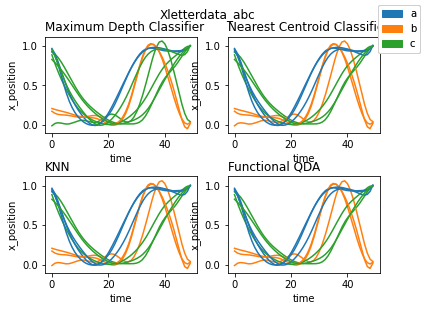

In [23]:
fig, axs = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.45, bottom=0.06)

X_test.plot(group=centroid_pred, group_names=categories, axes=axs[0][1])
axs[0][1].set_title('Nearest Centroid Classifier', loc='left')

X_test.plot(group=depth_pred, group_names=categories, axes=axs[0][0])
axs[0][0].set_title('Maximum Depth Classifier', loc='left')

X_test.plot(group=knn_pred, group_names=categories, axes=axs[1][0])
axs[1][0].set_title('KNN', loc='left')

X_test.plot(group=qda_pred, group_names=categories, axes=axs[1][1])
axs[1][1].set_title('Functional QDA', loc='left')

plt.show()

## Clustering

The existing clustering methods I can use are
- **FuzzyCMeans**
- **KMeans**

In [24]:
from skfda.exploratory.visualization.clustering import (
    ClusterMembershipLinesPlot,
    ClusterMembershipPlot,
    ClusterPlot,
)
from skfda.ml.clustering import FuzzyCMeans, KMeans

In [25]:
#Clustering is successful (only randomising order of clusters)
n_clusters = 3
seed = 0

kmeans = KMeans(n_clusters=n_clusters, random_state = seed)
kmeans.fit(X_FData)
print(kmeans.predict(X_FData))

[0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1]


In [26]:
colormap = plt.cm.get_cmap('tab10')
cluster_colors = colormap([0,2,1])
cluster_colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ]])

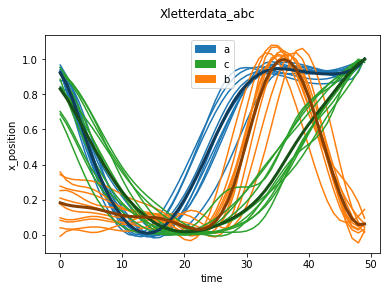

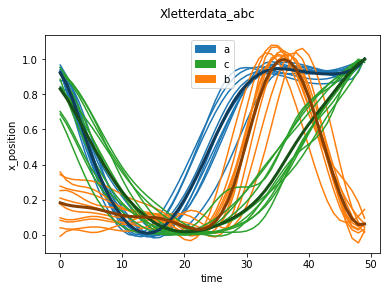

In [27]:
colormap = plt.cm.get_cmap('tab10')
cluster_colors = colormap([0,2,1])
cluster_labels = ['a','c','b']

ClusterPlot(kmeans,X_FData,cluster_colors = cluster_colors,cluster_labels=cluster_labels).plot()

In [28]:
fuzzy_kmeans = FuzzyCMeans(n_clusters=n_clusters,random_state=seed)
fuzzy_kmeans.fit(X_FData)
print(fuzzy_kmeans.predict(X_FData))

[0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1]


In [29]:
#Define sample colours for cluster plot (this time all X needs a colour)
color_byletter = [cluster_colors[i] for i in fuzzy_kmeans.predict(X_FData)]

Evaluate to what degree each entry resembles each cluster with a membershiplinesplot

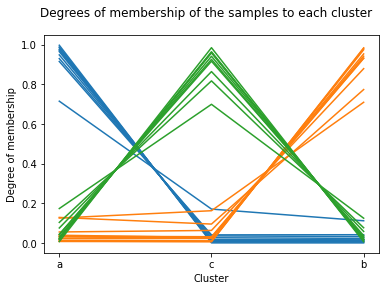

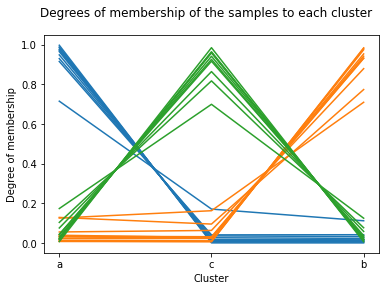

In [30]:
#Visualise how much each plot resembles centroid
ClusterMembershipLinesPlot(fuzzy_kmeans,X_FData,cluster_labels=cluster_labels,
                          sample_colors = color_byletter).plot()

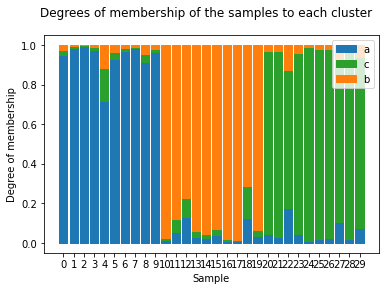

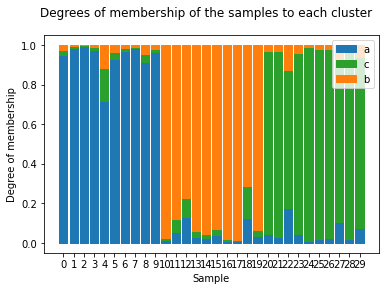

In [31]:
ClusterMembershipPlot(fuzzy_kmeans, X_FData, cluster_colors = cluster_colors,
                     cluster_labels = cluster_labels).plot()

## FPCA

The next step is to perform functional PCA, whereby the principal components of the data can be separated.

In [32]:
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)

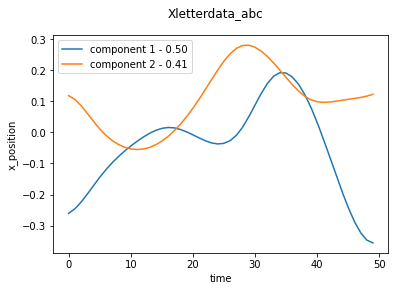

In [33]:
#2 Components in FPCA - just pass FDataGrid
fpca_discretized = FPCA(n_components=2)
fpca_discretized.fit(X_FData)
fpca_discretized.components_.plot()
plt.legend(labels=['component 1 - {:.2f}'.format(fpca_discretized.explained_variance_ratio_[0]),'component 2 - {:.2f}'.format(fpca_discretized.explained_variance_ratio_[1])])

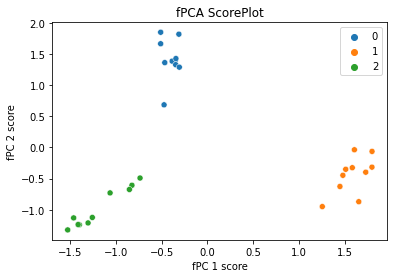

In [38]:
#get fPCA scores
scores = fpca_discretized.fit_transform(X_FData)
sns.scatterplot(x=scores[:, 0], y=scores[:, 1],hue = y,palette = ['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xlabel("fPC 1 score")
plt.ylabel("fPC 2 score")
plt.title("fPCA ScorePlot")
plt.show()